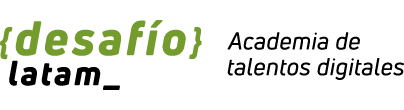

#<center><strong> <font color='green'>Regresión</font></strong></center>

##<font color='green'>Regularización en regresión lineal</font>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# MODELOS
from sklearn.model_selection import KFold
import sklearn.linear_model as lm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

# METRICAS DE REGRESION
from sklearn.metrics import r2_score, mean_squared_error

diamonds = sns.load_dataset('diamonds')
diamonds.head()

carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75

El dataset considera las siguientes variables:

* carat: peso del diamante (0.2--5.01)
* cut: calidad del corte (Fair, Good, Very Good, Premium, Ideal)
* color: color del diamante, desde D (mejor) a J (peor)
* clarity: una medida de la claridad del diamante, de (I1 (peor), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (mejor))
* depth: porcentaje de profundidad = z / mean(x, y) = 2 * z / (x + y) (43--79)
* table: ancho de la parte superior del diamante, en relación a su parte más ancha (43--95)
* price: precio en USD ($326--$18,823)
* x: largo en mm (0--10.74)
* y: ancho en mm (0--58.9)
* z: profundidad en mm (0--31.8)

Podemos definir una función para calcular las diferentes normas, que podemos hacer depender del parámetro p. Podemos notar que para $p=1$ obtenemos la norma Lasso, mientras que para $p=2$ se obtiene la norma euclideana.

In [ ]:
def norma_lp(x, p):
    return sum([xi**p for xi in x])**(1/p)

x = [3, 4]

norma_lp(x, 1), norma_lp(x, 2)

(7.0, 5.0)

Será necesario ahora escalar los datos, para lo que utilizaremos las funciones que nos proveen las bibliotecas. Seleccionamos las variables que vamos a utilizar y dividimos el conjunto de datos.

---



In [ ]:
scaler = StandardScaler()
diam = diamonds.drop(['cut', 'color', 'clarity'], axis=1)
diamonds_scaled = pd.DataFrame(scaler.fit_transform(diam), columns = diam.columns)

X = diamonds_scaled.loc[:, ['carat', 'depth', 'table', 'x', 'y', 'z']]
y = diamonds_scaled.loc[:, ['price']]

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

Vamos a definir una función llamada **cv_error** para calcular el error de validación cruzada (cross-validation error) para diferentes modelos de regresión lineal. La función toma varios argumentos, incluyendo los datos de entrenamiento **x_train** y **y_train,** el número de divisiones de validación cruzada k, el método de regresión a utilizar (method), y un parámetro de regularización (alpha).

In [ ]:
def cv_error(x_train, y_train, k, method = 'OLS', alpha = 1):

    # definimos los conjuntos de datos respectivos
    Xm, ym = x_train, y_train
    # creamos un objeto kFold para realizar la validación cruzada
    kf = KFold(n_splits=k)
    #Inicializamos rmse_cv a cero. Esta variable se utilizará para almacenar
    #la suma de los errores cuadráticos medios (RMSE) en cada iteración
    #de la validación cruzada.
    rmse_cv = 0
    # creamos una lista para almacenar los coeficientes
    coef_v = []

    # seleccionamos el método de regresión qu9e se utilizará
    if method is 'OLS':
        method_type = lm.LinearRegression(fit_intercept=False)
    elif method is 'ridge':
        method_type = lm.Ridge(alpha=alpha, fit_intercept=False)
    elif method is 'lasso':
        method_type = lm.Lasso(alpha = alpha, fit_intercept=False)
    elif method is 'enet':
        method_type = lm.ElasticNet(alpha=alpha, fit_intercept=False)
    else:
        #indicamos error, si es el caso
        raise TypeError("Method argument is not valid")

    #para cada particion:
    for train_index, validation_index in kf.split(Xm):
        # instanciamos el modelo
        method_type = method_type
        #ajustamos segun el modelo
        method_type.fit(Xm.iloc[train_index,], ym.iloc[train_index,])
        # almacenamos los coeficientes
        coef_v.append(method_type.coef_)
        # creamos las prediciones
        yhat_validation = method_type.predict(Xm.iloc[validation_index])
        # recalculamos rmse
        rmse_cv += np.mean(np.power(np.array(yhat_validation) - np.array(ym.iloc[validation_index]), 2))

    return rmse_cv

Aplicaremos ahora esta función para analizar cada modelo.

###<font color='green'>Ridge regression</font>

Veremos ahora el efecto en los parámetros al utilizar Ridge regression. Para ello:

*  Creamos la lista de valores de alpha a probar con base logarítmica (np.logspace)
* Creamos listas vacías para guardar el valor de los coeficientes del modelo y del error en esa combinación de hiper parámetros.
* Instanciamos el modelo Ridge con intercepto


In [ ]:
names_regressors = X_train.columns # guardamos los nombres de los atributos

alphas = np.logspace(0, 7, base = 10) # generamos un vector con los valores de la norma
coefs_ridge = [] #lista para guardar parámetros
cv_err_ridge = [] #lista para guardar parámetros
model_ridge = Ridge(fit_intercept = True) # instanciamos el modelo
tol = 0.1 # determinamos el umbral de tolerancia

A continuación, generaremos un loop para cada valor de alpha, donde se realizan las siguientes tareas:
* Se setea el parámetro alpha al modelo instanciado
* Se entrena el modelo con los datos de train
* Se guardan los coeficientes del modelo para ese valor de regularización
* Se utiliza la función cv_error, que calcula el error con cross validation para esos hiper parámetros
* Finalmente se encuentran los parámetros estimado y el error para cada valor de alpha.


In [ ]:
# para cada valor en el vector
for a in alphas:
    # estimamos el modelo con este valor
    model_ridge.set_params(alpha = a)
    model_ridge.fit(X_train, y_train)
    # guardamos el coeficiente estimado
    coefs_ridge.append(model_ridge.coef_)
    # generamos su estimado de validación cruzada
    cv_err_estimates = cv_error(X_train, y_train, k = 10, method = 'ridge', alpha = a)
    cv_err_ridge.append(np.mean(cv_err_estimates)) # OJO: estamos guardando la media del error de cv para cada alpha

Finalmente, realizamos un plot de los valores de los parámetros (coefs_ridge) para todos los valores de alpha y analizamos cómo se modifican al aumentar el valor del penalizador en la regularización.

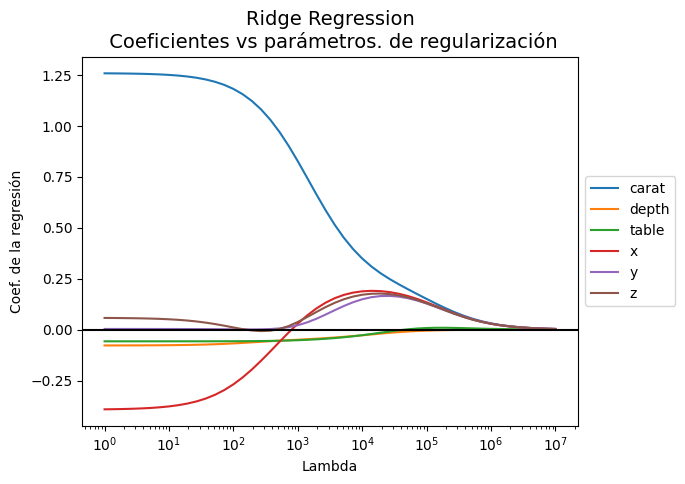

In [ ]:
names_regressors = X.columns

for y_arr, label in zip(np.squeeze(coefs_ridge).T, names_regressors):
    plt.plot(alphas, y_arr, label = label)
plt.legend()
plt.xscale("log")
plt.title("Ridge Regression\n Coeficientes vs parámetros. de regularización",
size = 14)
plt.axhline(0, color='black')
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.axis("tight")
plt.legend(loc="center left", bbox_to_anchor=(1, .5));

En el gráfico anterior se observa como van suavemente los valores tendiendo a 0, donde al tener un valor muy grande de penalización todos los parámetros se hacen 0.

Finalmente, se observa el error que hubo en cada punto y se traza una linea vertical en el punto que hubo un error más pequeño


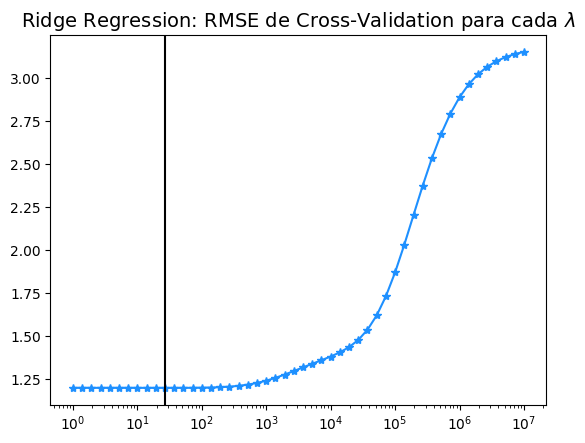

In [ ]:
plt.plot(alphas, np.sqrt(cv_err_ridge),"*-", color='dodgerblue')
plt.axvline(alphas[np.argmin(np.sqrt(cv_err_ridge))], color='black', label='Minimo error')
plt.xscale("log")
plt.title("Ridge Regression: RMSE de Cross-Validation para cada $\lambda$", fontsize = 14);

###<font color='green'>Lasso regression</font>

Se siguen los mismos pasos vistos anteriormente, pero utilizando el método Lasso de sklearn. Para ello:
* instanciamos el modelo y creamos las listas vacías para ir almacenando los errores y coeficientes
* Generamos un loop para cada valor de alpha poder calcular el error y los coeficientes.
* Graficamos el movimiento de los coeficientes y el el error para cada valor de alpha utilizado.

Se puede observar que para cada valor de alpha los parámetros no oscilan suavemente en torno a cero, sino que se eliminan de golpe.


In [ ]:
names_regressors = X_train.columns # guardamos los nombres de los atributos
alphas = np.logspace(0, -3, base = 10) # generamos un vector con los valores de la norma
model_lasso = Lasso(fit_intercept = True) # instanciamos el modelo

coefs_lasso = []
cv_err_lasso = []

In [ ]:
# para cada valor en el vector
for a in alphas:
    # estimamos el modelo con éste
    model_lasso.set_params(alpha = a)
    model_lasso.fit(X_train, y_train)
    # guardamos el coeficiente estimado
    coefs_lasso.append(model_lasso.coef_)
    # generamos su estimado de validación cruzada
    cv_err_estimates = cv_error(X_train, y_train, k = 5, method = 'lasso', alpha = a)
    cv_err_lasso.append(np.mean(cv_err_estimates))

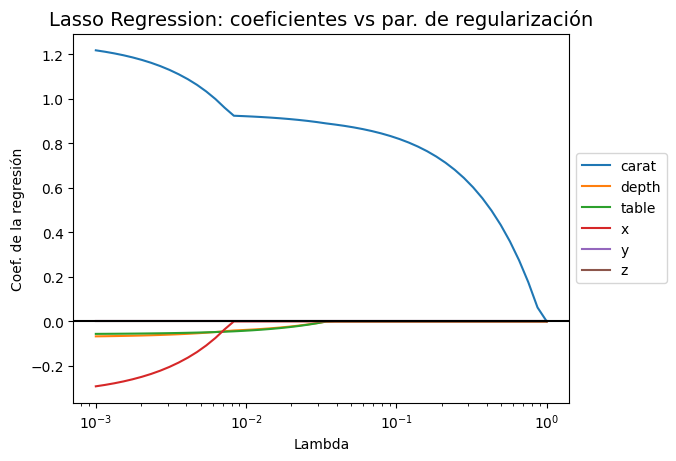

In [ ]:
names_regressors = X.columns

for y_arr, label in zip(np.squeeze(coefs_lasso).T, names_regressors):
    plt.plot(alphas, y_arr, label = label)
plt.legend()
plt.xscale("log")
plt.title("Lasso Regression: coeficientes vs par. de regularización",
size = 14)
plt.axhline(0, color='black')
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.axis("tight")
plt.legend(loc="center left", bbox_to_anchor=(1, .5));

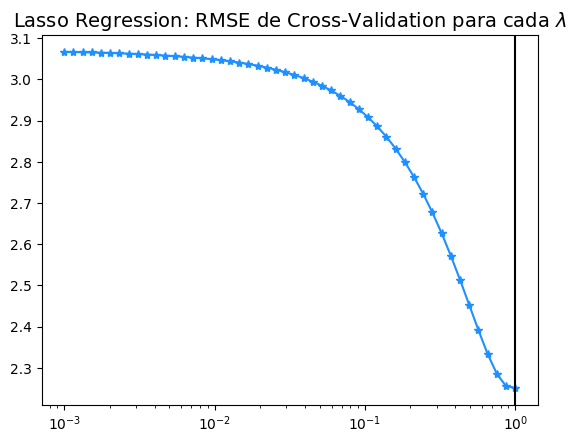

In [ ]:
plt.plot(alphas, np.sqrt(cv_err_lasso),"*-", color='dodgerblue')
plt.axvline(alphas[np.argmin(np.sqrt(cv_err_lasso))], color='black', label='Minimo error')
plt.xscale("log")
plt.title("Lasso Regression: RMSE de Cross-Validation para cada $\lambda$", fontsize = 14);

###<font color='green'>Elastic net</font>

Aplicamos esencialmente los mismos pasos que en los métodos anteriores. Ya que elastic net combina ambos métodos, podemos observar en el gráfico final que existe una combinación entre los comportamientos vistos anteriormente.

In [ ]:
names_regressors = X_train.columns # guardamos los nombres de los atributos
alphas = np.logspace(0, -3, base = 10) # generamos un vector con los valores de la norma
model_elastic_net = ElasticNet(fit_intercept = True) # instanciamos el modelo

coefs_elastic_net = []
cv_err_elastic_net = []

In [ ]:
# para cada valor en el vector
for a in alphas:
    # estimamos el modelo con éste
    model_elastic_net.set_params(alpha = a)
    model_elastic_net.fit(X_train, y_train)
    # guardamos el coeficiente estimado
    coefs_elastic_net.append(model_elastic_net.coef_)
    # generamos su estimado de validación cruzada
    cv_err_estimates = cv_error(X_train, y_train, k = 5, method = 'lasso', alpha = a)
    cv_err_elastic_net.append(np.mean(cv_err_estimates))

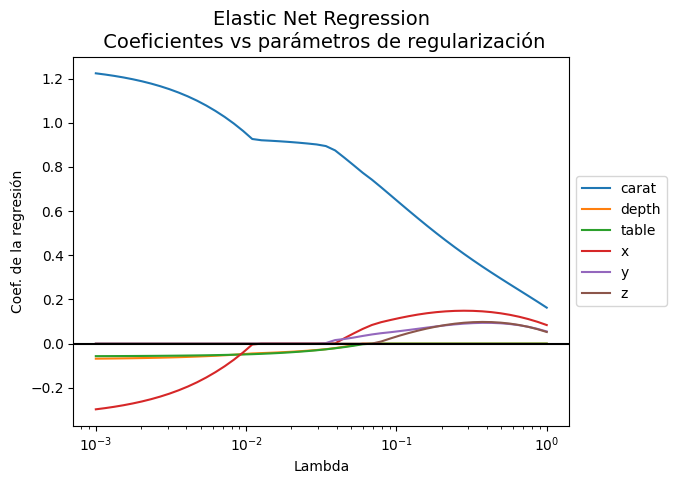

In [ ]:
names_regressors = X.columns

for y_arr, label in zip(np.squeeze(coefs_elastic_net).T, names_regressors):
    plt.plot(alphas, y_arr, label = label)
plt.legend()
plt.xscale("log")
plt.title("Elastic Net Regression\n Coeficientes vs parámetros de regularización",
size = 14)
plt.axhline(0, color='black')
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.axis("tight")
plt.legend(loc="center left", bbox_to_anchor=(1, .5));

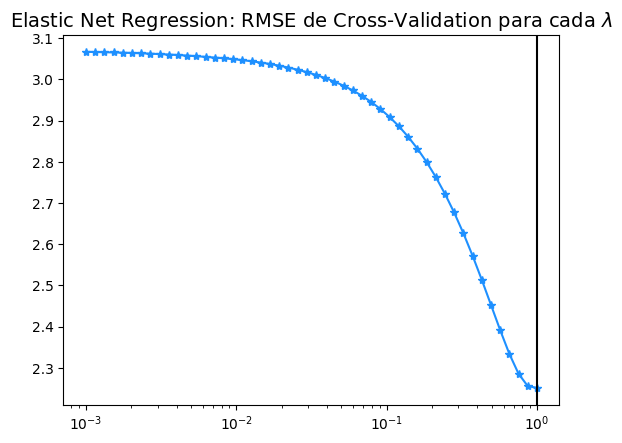

In [ ]:
plt.plot(alphas, np.sqrt(cv_err_elastic_net),"*-", color='dodgerblue')
plt.axvline(alphas[np.argmin(np.sqrt(cv_err_elastic_net))], color='black', label='Minimo error')
plt.xscale("log")
plt.title("Elastic Net Regression: RMSE de Cross-Validation para cada $\lambda$", fontsize = 14);

<center><strong>¡Regresemos a nuestra presentación!</strong></center>